In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [4]:
 from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display
import warnings

warnings.filterwarnings("ignore")

In [6]:
file_path = "/content/drive/MyDrive/python_data_analysis/data/market-price.csv"
bitcoin_df = pd.read_csv(file_path, names=['day', 'price'])

# 1. 데이터 확인하기

In [7]:
bitcoin_df.shape

(365, 2)

In [8]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [9]:
bitcoin_df.head(5)

,day,price
0,2017-08-27 00:00:00,4354.308333
1,2017-08-28 00:00:00,4391.673517
2,2017-08-29 00:00:00,4607.985450
3,2017-08-30 00:00:00,4594.987850
4,2017-08-31 00:00:00,4748.255000


In [10]:
bitcoin_df.tail(5)

,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


## 데이터 시각화하기

In [11]:
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])
bitcoin_df.set_index('day', inplace=True)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


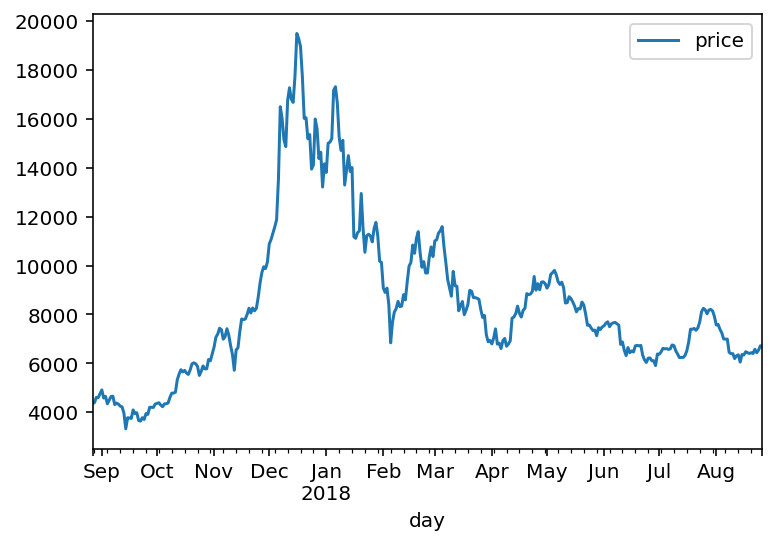

In [12]:
bitcoin_df.plot()
plt.show()

# 2. 시계열 예측: ARIMA

* AR(Auto Regression)모델로 자신의 과거를 정보로 사용한다. "현재는 과거를 참고해서 계혹된다" 
* MA(Moving Average)모델로 이전 항에서의 오차를 이용하여 현재 항의 상태를 추론한다.
* ARIMA(Auto Regressive Integrated Moving Average): ARMA 모델에 추세변동의 경향성(momentum)까지 반영한 방법

In [13]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(bitcoin_df.price.values, order=(2, 1, 2))
model_fit = model.fit(trend='c', full_output=True, disp=True)

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2780.074
Method:                       css-mle   S.D. of innovations            501.536
Date:                Tue, 23 Mar 2021   AIC                           5572.148
Time:                        06:22:37   BIC                           5595.531
Sample:                             1   HQIC                          5581.442
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3951     26.944      0.237      0.813     -46.414      59.204
ar.L1.D.y      0.4496      0.029     15.512      0.000       0.393       0.506
ar.L2.D.y     -0.9622      0.023    -42.314      0.0

* 상수항을 제외한 모든 계수가 유의미하다.

   = AR과 MA를 2로 설정한 것이 유효했다.

## ARIMA 결과 시각화하기

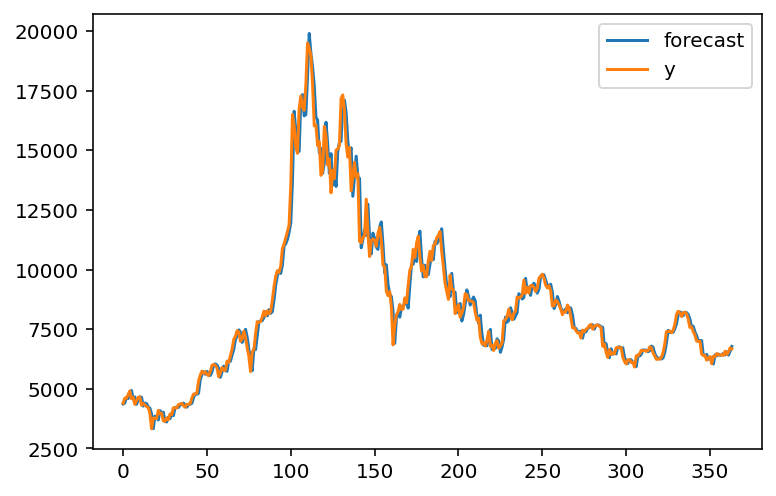

In [14]:
# 학습한 모델에 train dataset을 넣었을 때의 시계열 예측 결과
fig = model_fit.plot_predict()

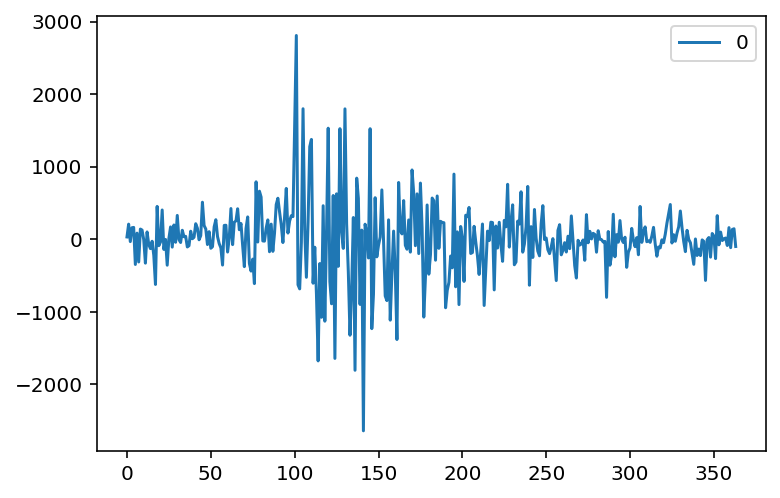

In [15]:
# 실제값과 오차값 사이의 오차변동
# 폭이 일정할 때 좋은 예측 모델을 학습시킨 것.
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

## ARIMA 평가하기

In [16]:
test_file_path = "/content/drive/MyDrive/python_data_analysis/data/market-price-test.csv"
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

In [17]:
bitcoin_test_df.head(10)

,ds,y
0,2018-08-27 00:00:00,6719.266154
1,2018-08-28 00:00:00,7000.040000
2,2018-08-29 00:00:00,7054.276429
3,2018-08-30 00:00:00,6932.662500
4,2018-08-31 00:00:00,6981.946154


In [18]:
forecast_data = model_fit.forecast(steps=5)   # train dataset을 이용해 5일 뒤 예측하기
pred_y = forecast_data[0].tolist()  # 앞으로 5일 동안의 미래를 test로 사용
test_y = bitcoin_test_df.y.values   # 실제 미래 5일의 데이터

In [19]:
forecast_data

(array([6667.3801006 , 6624.5263375 , 6620.60305382, 6669.74828911,
        6705.29388784]),
 array([ 501.53574487,  731.1161293 ,  905.44113295, 1037.14505156,
        1147.49971646]),
 array([[5684.38810369, 7650.3720975 ],
        [5191.56505555, 8057.48761945],
        [4845.97104313, 8395.23506452],
        [4636.98134131, 8702.51523692],
        [4456.2357713 , 8954.35200438]]))

In [20]:
pred_y_lower = []
pred_y_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    pred_y_lower.append(lower)
    upper = lower_upper[1]
    pred_y_upper.append(upper)    

In [21]:
print(pred_y_lower)
print(pred_y_upper)

[5684.388103692396, 5191.56505555086, 4845.971043125024, 4636.981341311671, 4456.235771301192]
[7650.372097498344, 8057.487619454856, 8395.235064521772, 8702.515236915222, 8954.352004378]


## ARIMA RMSE: 309.00

In [22]:
from sklearn.metrics import mean_squared_error
from math import sqrt

arima_rmse = sqrt(mean_squared_error(pred_y, test_y))
arima_rmse

309.0099117445821

## ARIMA 평가 시각화하기

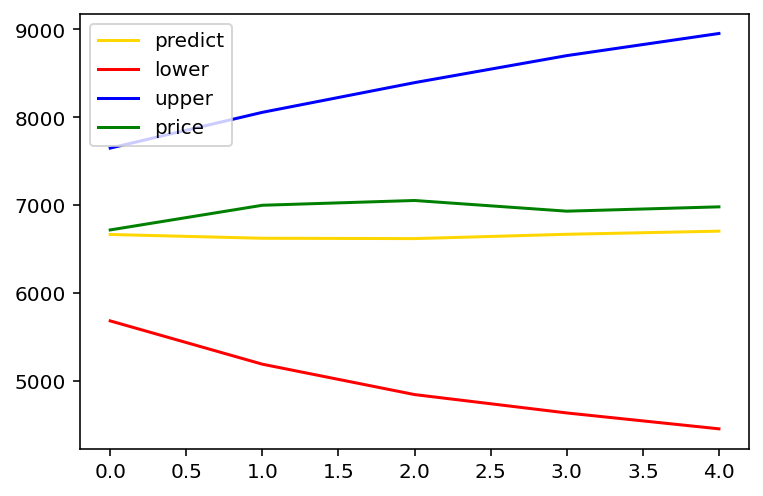

In [23]:
# ARIMA 모델이 예측한 가격 그래프
plt.plot(pred_y, color='gold', label="predict")

# ARIMA 모델이 예측한 최저가격 그래프
plt.plot(pred_y_lower, color="red", label="lower")

# ARIMA 모델이 예측한 최저가격 그래프
plt.plot(pred_y_upper, color="blue", label="upper")

# 실제 가격 그래프
plt.plot(test_y, color="green", label="price")

plt.legend()
plt.show()

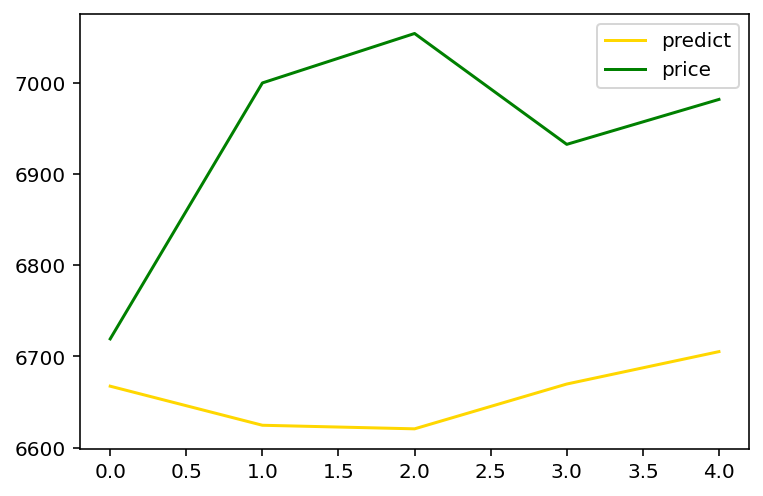

In [24]:
plt.plot(pred_y, color='gold', label="predict")
plt.plot(test_y, color="green", label="price")

plt.legend()
plt.show()

* 좋은 예측을 하지 못함. 
* 앞으로 5일동안 상승할 것이라는 큰 경향 정도 예측.

# 3. 시계열 예측: Facebook Prophet
* Additive 모델에 기반하여 시계열 데이터의 트렌드성(연간/월간/일간) 예측.
* 회귀분석의 단점을 극복하기 위하여 각 feature마다 비선형적 적합을 가능하도록 함.
* feature명을 'ds', 'y'로 변경해서 사용.

In [25]:
from fbprophet import Prophet

In [26]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
bitcoin_df.head(5)

,ds,y
0,2017-08-27 00:00:00,4354.308333
1,2017-08-28 00:00:00,4391.673517
2,2017-08-29 00:00:00,4607.985450
3,2017-08-30 00:00:00,4594.987850
4,2017-08-31 00:00:00,4748.255000


In [27]:
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True,
                  daily_seasonality=True,
                  changepoint_prior_scale=0.5)  # 수치가 높을수록 과적합.

prophet.fit(bitcoin_df)

In [28]:
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6870.046369,6226.737711,7519.466164
366,2018-08-28,6958.173352,6276.243921,7612.968180
367,2018-08-29,6966.981989,6261.138458,7752.086233
368,2018-08-30,7028.094432,6270.973041,7757.646159
369,2018-08-31,7101.738804,6304.882061,7863.334891


In [35]:
forecast_data.shape

(370, 22)

## Prophet 결과 시각화하기

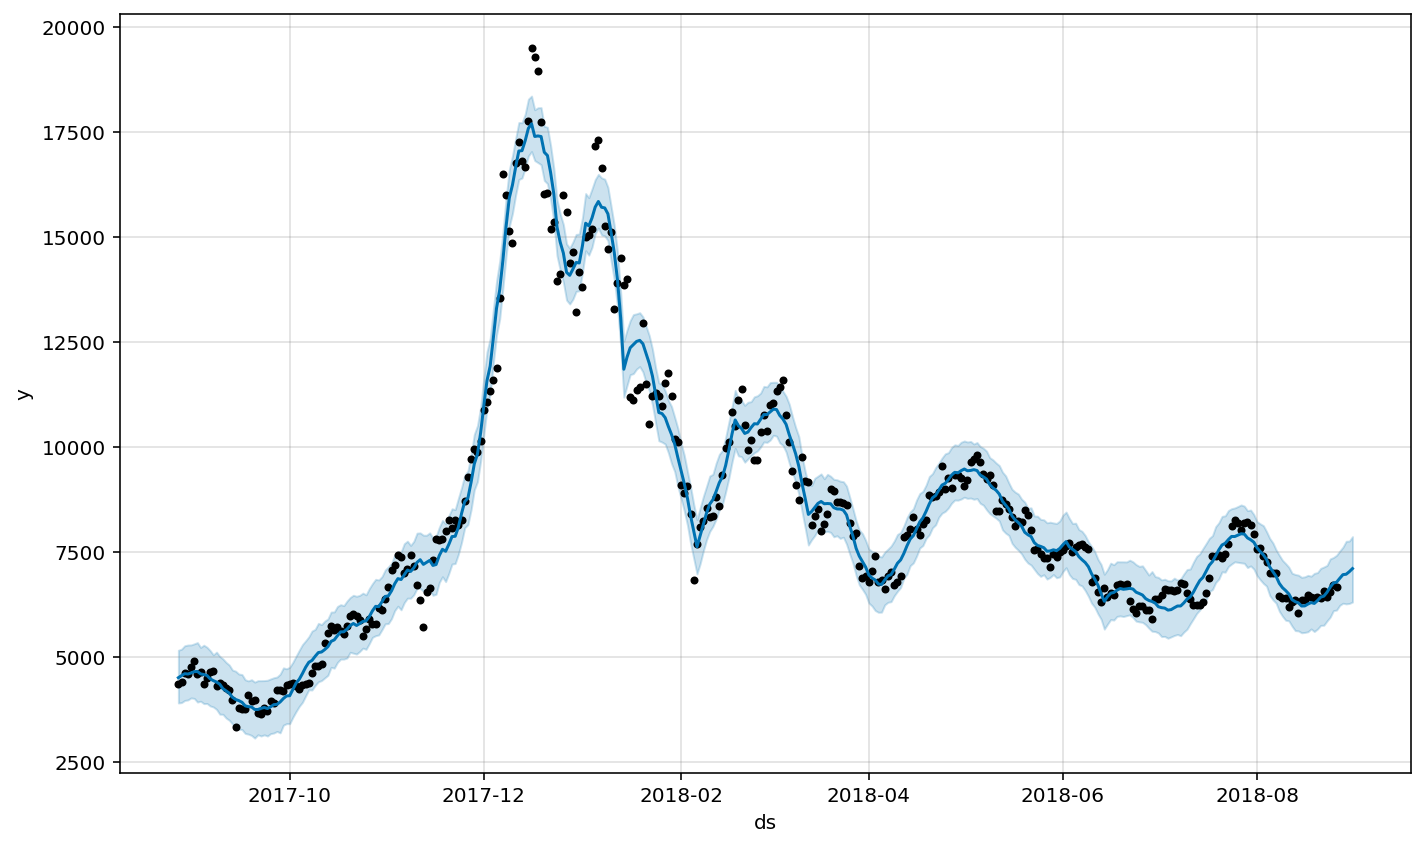

In [29]:
fig1 = prophet.plot(forecast_data)

* 검은 점: 실제 가격
* 파란 선: 예측 가격
* train dataset에 대한 예측은 꽤 정확한 편. --별 소용없음

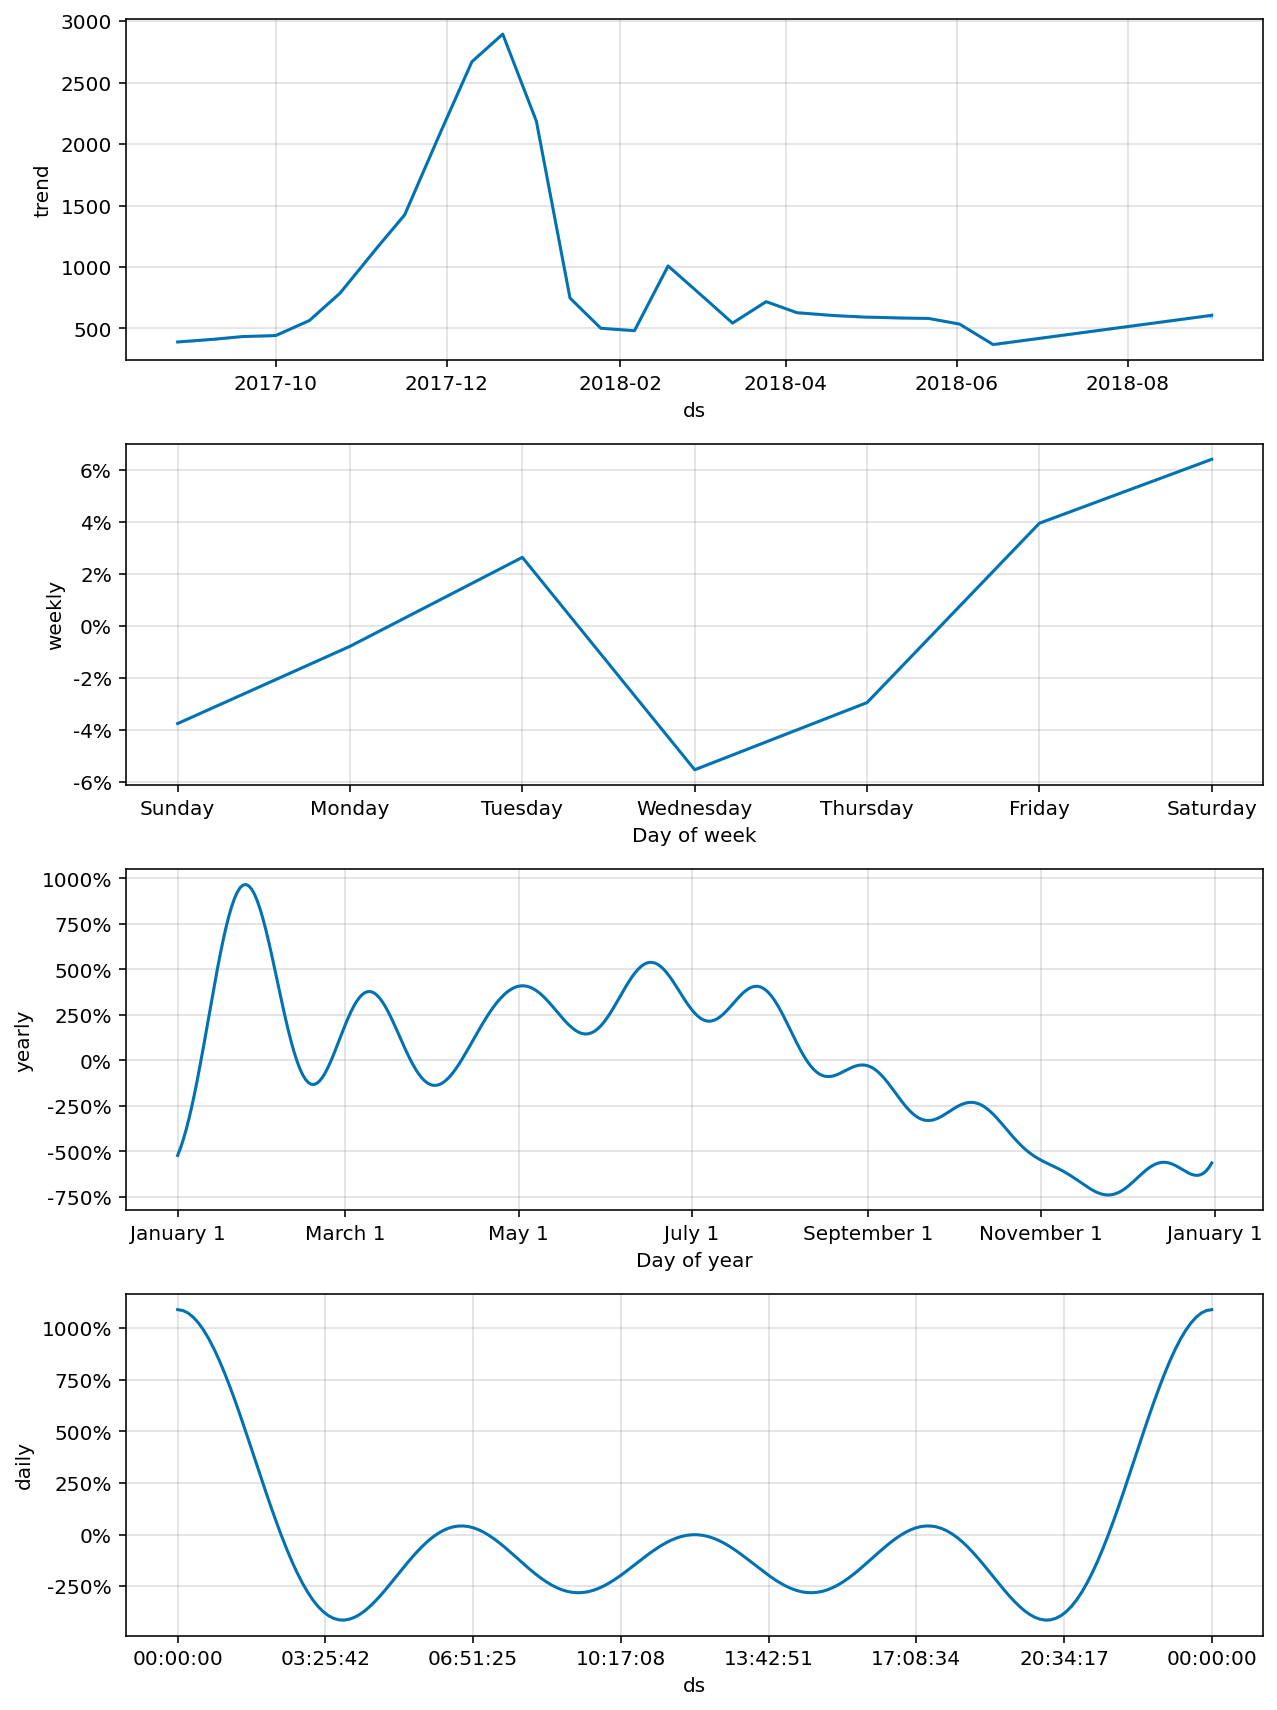

In [30]:
# 트렌드 정보 시각화
fig2 = prophet.plot_components(forecast_data)

* seasonality_mode 파라미터를 설정한 경우에만 가능한 기능. 

## Prophet 평가하기

In [31]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:]   # 마지막 5일 예측
test_y = bitcoin_test_df.y.values         # 실제 5일 데이터

pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

## Prophet RMSE: 105.41

In [32]:
prophet_rmse = sqrt(mean_squared_error(pred_y, test_y))
prophet_rmse

105.41853842279897

## Prophet 평가 시각화하기

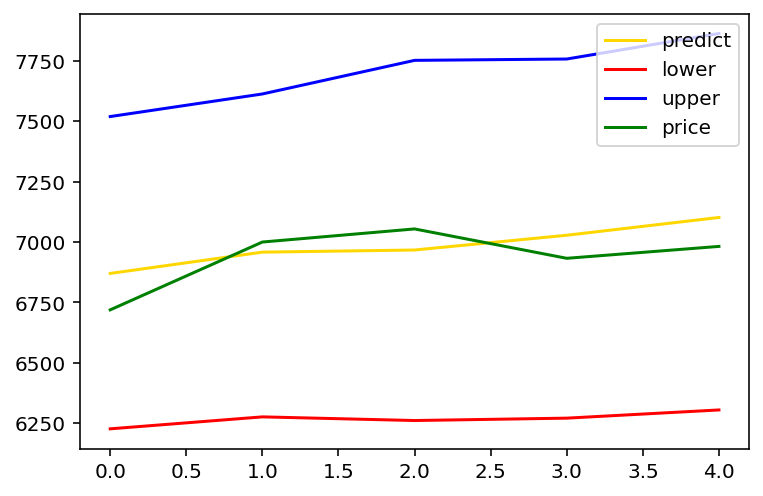

In [33]:
# Prophet 모델이 예측한 가격 그래프
plt.plot(pred_y, color='gold', label="predict")

# Prophet 모델이 예측한 최저가격 그래프
plt.plot(pred_y_lower, color="red", label="lower")

# Prophet 모델이 예측한 최저가격 그래프
plt.plot(pred_y_upper, color="blue", label="upper")

# 실제 가격 그래프
plt.plot(test_y, color="green", label="price")

plt.legend()
plt.show()

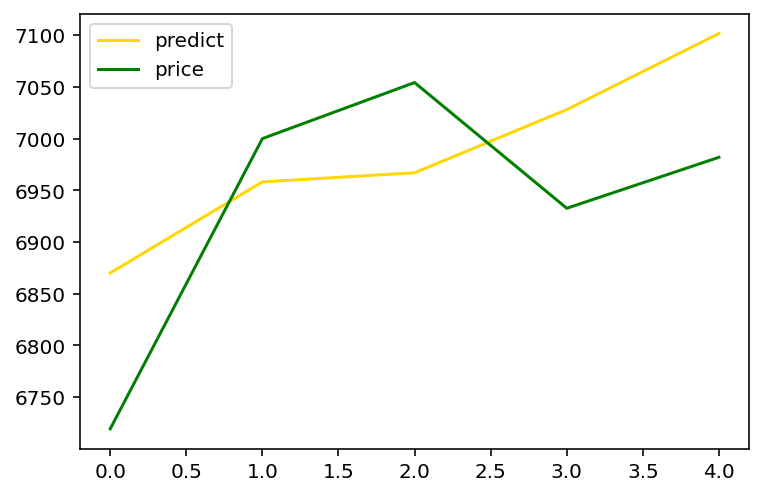

In [34]:
plt.plot(pred_y, color='gold', label="predict")
plt.plot(test_y, color="green", label="price")

plt.legend()
plt.show()

## Prophet 성능 높이기

### 상한값/하한값 지정하기

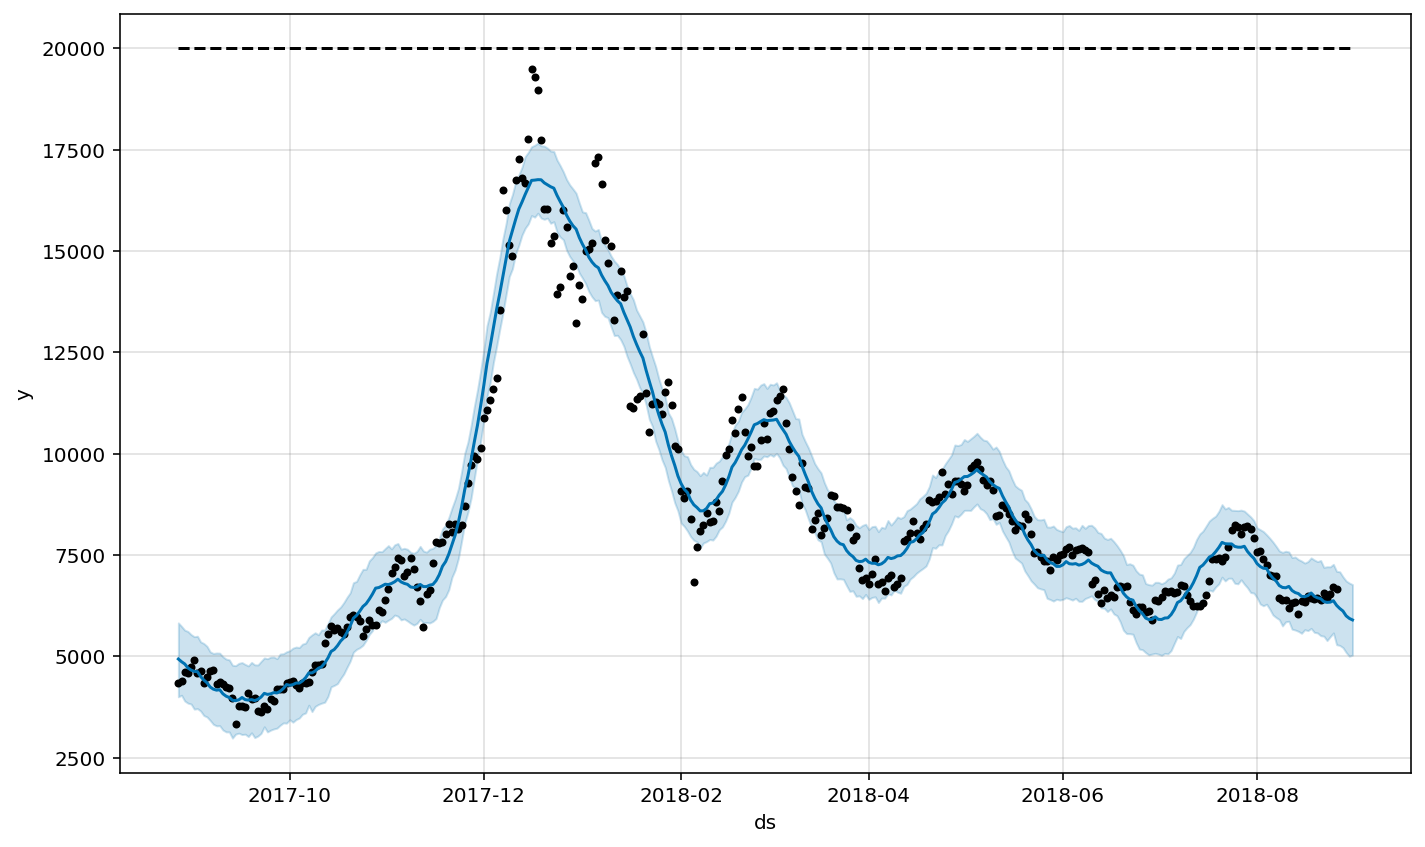

In [36]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])

# 상한가 설정하기
bitcoin_df['cap'] = 20000

prophet = Prophet(seasonality_mode="multiplicative",
                  growth='logistic',
                  yearly_seasonality=True,
                  weekly_seasonality=True, 
                  daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

future_data = prophet.make_future_dataframe(periods=5, freq='d')

future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)


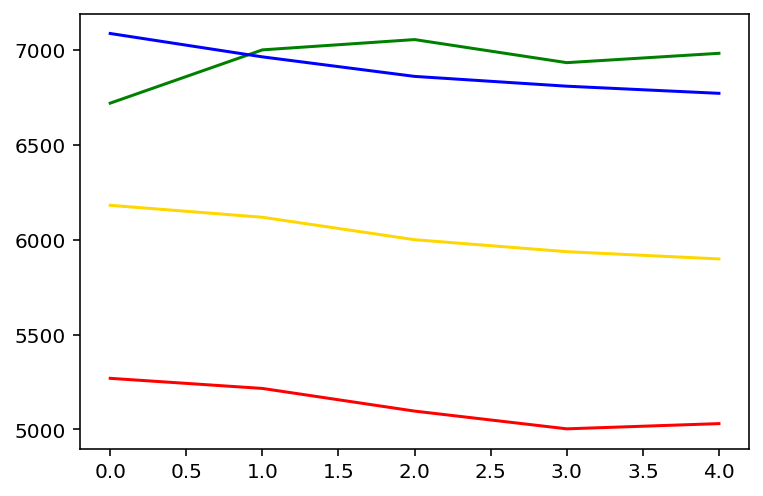

In [37]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color="gold", label="predict")
plt.plot(test_y, color="green", label="price")
plt.plot(pred_y_lower, color="red", label="lower")
plt.plot(pred_y_upper, color="blue", label="upper")

* 형편없는 결과. 
* 이유: 상한가의 개념이 큰 의미가 없는 데이터에 상한가를 적용했기 때문. 

### 이상치 제거하기
* 이상치에 해당하는 데이터를 None으로 설정하기

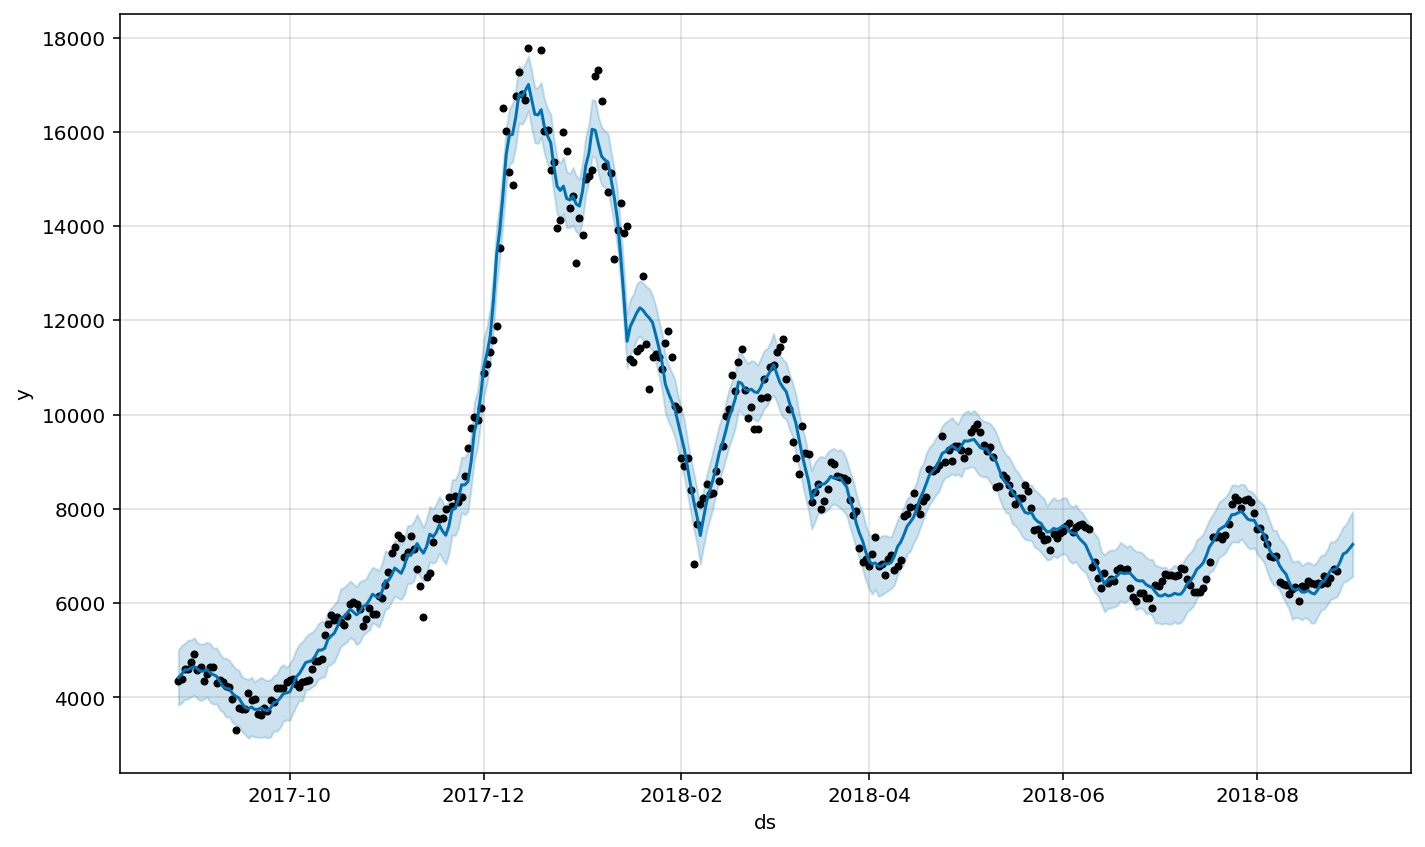

In [46]:
# 18000이상의 데이터는 이상치라고 판단하기
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

prophet = Prophet(seasonality_mode="multiplicative",
                  yearly_seasonality=True,
                  weekly_seasonality=True, 
                  daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

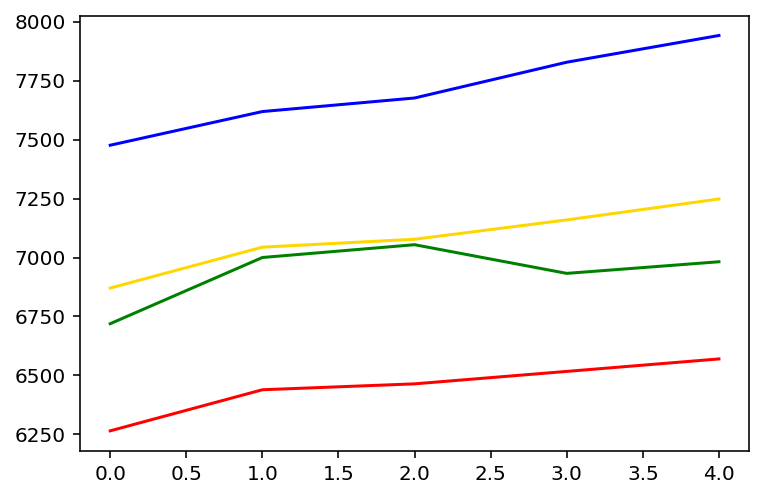

In [47]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color="gold", label="predict")
plt.plot(test_y, color="green", label="price")
plt.plot(pred_y_lower, color="red", label="lower")
plt.plot(pred_y_upper, color="blue", label="upper")

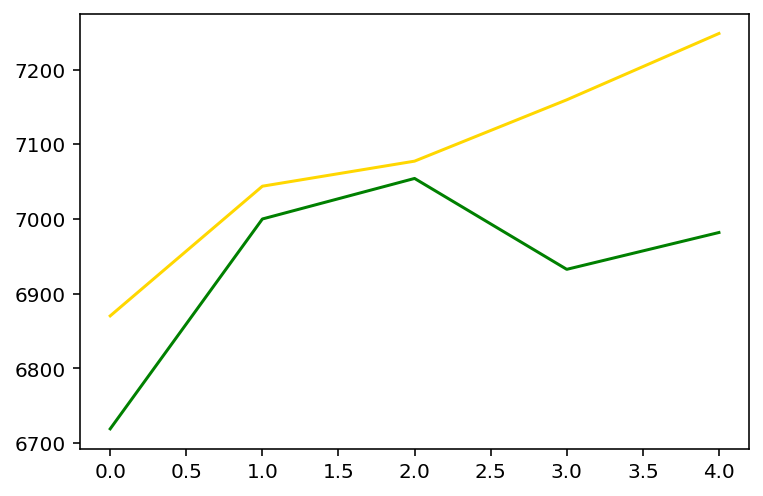

In [50]:
plt.plot(pred_y, color="gold", label="predict")
plt.plot(test_y, color="green", label="price")

In [49]:
new_prophet_rmse = sqrt(mean_squared_error(pred_y, test_y))
new_prophet_rmse

171.83159828333595

* RMSE값이 상승했지만 트렌드는 더 잘 예측하고 있다. 